# ***Importing all the libraries that are required to build this model***

In [1]:
from google.colab import drive
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import sklearn.model_selection as sk
import plotly.express as px
import re
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Mounting the drive on Google Colab**

In [7]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
os.chdir('/content/drive/My Drive/Data')
os.listdir()

['test.csv', 'train.csv', 'countryMap.txt']

# ***Loading the Dataset*** 


In [0]:
df = pd.read_csv('/content/drive/My Drive/Data/train.csv')
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


(82657, 12)

In [0]:
df.head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [0]:
df.describe()

,points,price
count,82657.000000,77088.000000
mean,88.544564,36.922232
std,3.099649,43.698346
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


# ***Feature Extraction and Feature Engineering***

In [0]:
#We can extract the year information(vintages) from review_title attribute
df_vintage = df
vintage=[]
for value in df_vintage['review_title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult :
        vintage.append(regexresult.group())
    else : 
      vintage.append(None)

df_vintage['year'] = vintage
print("We extracted %d years from the wine review_title and %d did not have a year." %(len(df_vintage[df_vintage['year'].notna()]), len(df_vintage[df_vintage['year'].isna()].index)))
df_vintage['year'].describe()

We extracted 80129 years from the wine review_title and 2528 did not have a year.


count     80129
unique       38
top        2012
freq      10379
Name: year, dtype: object

In [0]:
#We can add 3-address or 2-address country codes for each training example
df_country = df
df_country = df_country.replace({'country': r'USA?'}, {'country': 'United States of America'}, regex=True)
dfcountry_map = pd.read_csv('countryMap.txt',sep='\t')
df_country = df_country.merge(dfcountry_map, on='country')
df_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82555 entries, 0 to 82554
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63163 non-null  object 
 1   country             82555 non-null  object 
 2   review_title        82555 non-null  object 
 3   review_description  82555 non-null  object 
 4   designation         58915 non-null  object 
 5   points              82555 non-null  int64  
 6   price               76994 non-null  float64
 7   province            82555 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82555 non-null  object 
 11  variety             82555 non-null  object 
 12  year                80042 non-null  object 
 13  country-2let        82555 non-null  object 
 14  country-3let        82555 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 10.

# ***Data Visualization***

In [0]:
#Get label frequencies in descending order
label_frequencies = df['variety'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

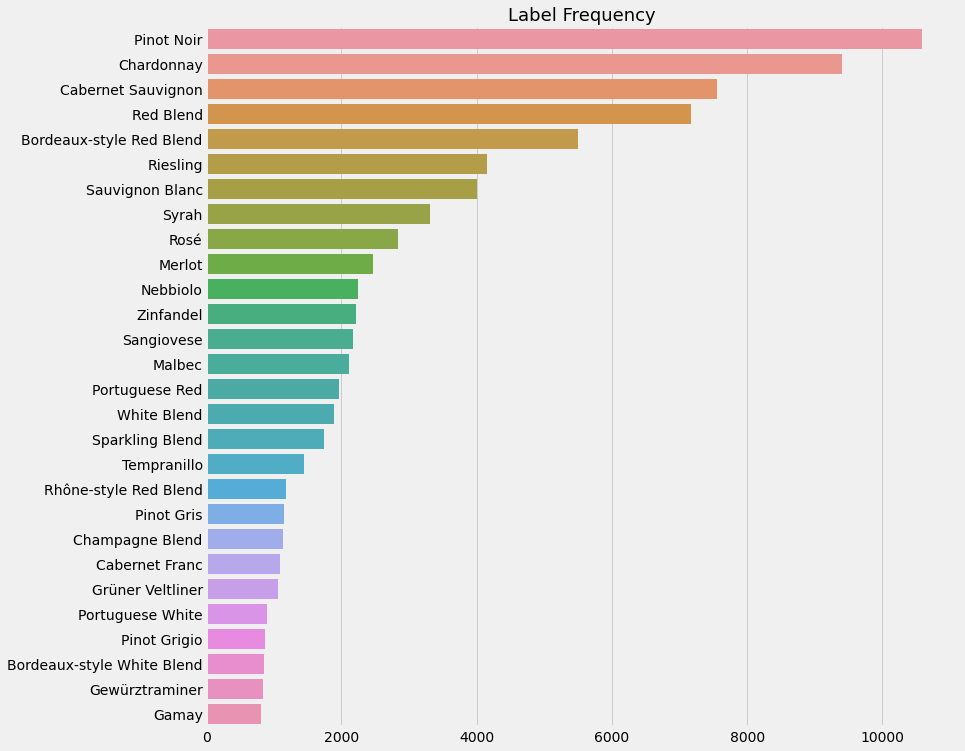

In [0]:
# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,12))
sns.barplot(y=label_frequencies.index.values, x=label_frequencies, order=label_frequencies.index)
plt.title("Label Frequency", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# ***Preparing Dataset for Training***

In [0]:
dfWineClassifier = df[['review_description', 'variety']]
dfWineClassifier.shape

(82657, 2)

In [0]:
dfWineClassifier.head(5)

,review_description,variety
0,"Classic Chardonnay aromas of apple, pear and h...",Chardonnay
1,This wine is near equal parts Syrah and Merlot...,Red Blend
2,Barolo Conca opens with inky dark concentratio...,Nebbiolo
3,It's impressive what a small addition of Sauvi...,Bordeaux-style White Blend
4,"This ripe, sweet wine is rich and full of drie...",Malbec


### ***Locating Null or NaN values***

In [0]:
print(dfWineClassifier.isnull().sum())
print()

review_description    0
variety               0
dtype: int64



In [0]:
#If there had been null or NaN values, we would have removed that row
dfWineClassifier=dfWineClassifier.dropna(subset=['review_description', 'variety'])
print('Removed ' + str(df.shape[0]-dfWineClassifier.shape[0]) + ' rows with empty values.' + "\n")


Removed 0 rows with empty values.



#### ***Converting text into numeric values, using words as a vocabulary via the tensorflow tokenizer.***

In [0]:
# Length of dictionary
NUM_WORDS = 4000
# Length of each review description
SEQ_LENGTH = 256
# Creating tokenizer 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>')
# Creating a vocabulary for our review_description(we will use the same dictionary/vocabulary during testing)
tokenizer.fit_on_texts(dfWineClassifier['review_description'])

In [0]:
# Convert training text data to numerical indexes (tokenization of the entire corpus)
wine_seqs_train = tokenizer.texts_to_sequences(dfWineClassifier['review_description'])
print(len(wine_seqs_train[0]))

32


In [0]:
# When we train our model, we need sequences to be in the same size, that’s why we use padding.
wine_seqs_train=tf.keras.preprocessing.sequence.pad_sequences(wine_seqs_train, maxlen=SEQ_LENGTH, padding="post")
print(len(wine_seqs_train[0]))

256


In [0]:
# This is our dictionary/vocabulary of top 4000 words
print(tokenizer.word_index.items())

dict_items([('<UNK>', 1), ('and', 2), ('the', 3), ('a', 4), ('of', 5), ('with', 6), ('this', 7), ('is', 8), ('wine', 9), ('in', 10), ('flavors', 11), ('it', 12), ('to', 13), ('fruit', 14), ('on', 15), ('that', 16), ('palate', 17), ('aromas', 18), ('acidity', 19), ('from', 20), ('finish', 21), ('tannins', 22), ('but', 23), ("it's", 24), ('drink', 25), ('cherry', 26), ('black', 27), ('ripe', 28), ('are', 29), ('has', 30), ('for', 31), ('red', 32), ('by', 33), ('spice', 34), ('as', 35), ('notes', 36), ('dry', 37), ('its', 38), ('oak', 39), ('rich', 40), ('an', 41), ('fresh', 42), ('berry', 43), ('full', 44), ('nose', 45), ('now', 46), ('plum', 47), ('fruits', 48), ('blend', 49), ('soft', 50), ('well', 51), ('sweet', 52), ('light', 53), ('texture', 54), ('apple', 55), ('cabernet', 56), ('blackberry', 57), ('crisp', 58), ('dark', 59), ('bodied', 60), ('through', 61), ('offers', 62), ('shows', 63), ('while', 64), ('vanilla', 65), ('at', 66), ('citrus', 67), ('very', 68), ('white', 69), ('mor

# ***Preparing Label Data***

In [0]:
# Total classes/labels
label_words = list(label_frequencies.index)
print(label_words)
num_labels = len(label_words)
print("\nThere are total "  + str(num_labels) + " different categories of wine.")

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec', 'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo', 'Rhône-style Red Blend', 'Pinot Gris', 'Champagne Blend', 'Cabernet Franc', 'Grüner Veltliner', 'Portuguese White', 'Pinot Grigio', 'Bordeaux-style White Blend', 'Gewürztraminer', 'Gamay']

There are total 28 different categories of wine.


In [0]:
#Preparing Label Dataframe
wine_labels_train=pd.DataFrame({'variety': dfWineClassifier['variety']})
wine_labels_train.head(5)

,variety
0,Chardonnay
1,Red Blend
2,Nebbiolo
3,Bordeaux-style White Blend
4,Malbec


In [0]:
#Removing Blank spaces from labels
wine_labels_train = wine_labels_train.replace(' ', '_', regex=True)
wine_labels_train.head(5)

,variety
0,Chardonnay
1,Red_Blend
2,Nebbiolo
3,Bordeaux-style_White_Blend
4,Malbec


In [0]:
# List of labels
wine_labels_list = []
for item in wine_labels_train['variety']:
    wine_labels_list.append(str(item))
print(len(wine_labels_list))

82657


In [0]:
# Creating tokenizer for labels
label_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n')
label_tokenizer.fit_on_texts(wine_labels_list)

In [0]:
# Dictionary assigning integer values to labels
print(label_tokenizer.word_index)

{'pinot_noir': 1, 'chardonnay': 2, 'cabernet_sauvignon': 3, 'red_blend': 4, 'bordeaux-style_red_blend': 5, 'riesling': 6, 'sauvignon_blanc': 7, 'syrah': 8, 'rosé': 9, 'merlot': 10, 'nebbiolo': 11, 'zinfandel': 12, 'sangiovese': 13, 'malbec': 14, 'portuguese_red': 15, 'white_blend': 16, 'sparkling_blend': 17, 'tempranillo': 18, 'rhône-style_red_blend': 19, 'pinot_gris': 20, 'champagne_blend': 21, 'cabernet_franc': 22, 'grüner_veltliner': 23, 'portuguese_white': 24, 'pinot_grigio': 25, 'bordeaux-style_white_blend': 26, 'gewürztraminer': 27, 'gamay': 28}


In [0]:
# Creating a numpy array of labels
wine_label_seq_train = np.array(label_tokenizer.texts_to_sequences(wine_labels_list))

In [0]:
# Reversing the mapping of the dictionaries
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
reverse_label_index = dict([(value, key) for (key, value) in label_tokenizer.word_index.items()])

# Function to decode review description back to text
def decode_description(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

#Function to decode label back to text
def decode_label(text):
    return ' '.join([reverse_label_index.get(i, '?') for i in text])

# ***Splitting Data into Training and Validation***

In [0]:
x_train, x_valid, y_train, y_valid = sk.train_test_split(wine_seqs_train,
                                                    wine_label_seq_train,
                                                    test_size=0.20,
                                                    shuffle=True)

In [0]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((66125, 256), (16532, 256), (66125, 1), (16532, 1))

In [0]:
# Type Conversion to float32
x_train = x_train.astype("float32")
x_valid = x_valid.astype("float32")
y_train = y_train.astype("float32")
y_valid = y_valid.astype("float32")


# ***Creating the Model***

In [0]:
# Variable Declaration 
EMBEDDING_SIZE = 256
EMBEDDING_SIZE_1 = 128
EMBEDDING_SIZE_OUT = (num_labels+1)
BATCH_SIZE = 512  # This can really speed things up
EPOCHS = 30

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
                             tf.keras.layers.Conv1D(EMBEDDING_SIZE, 3, activation='relu'),  
                             tf.keras.layers.GlobalMaxPooling1D(), 
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(EMBEDDING_SIZE_1, activation='relu'), 
                             tf.keras.layers.Dense(EMBEDDING_SIZE_OUT, activation='softmax')
                             ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         1024000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 29)                3741      
Total params: 1,257,501
Trainable params: 1,257,501
Non-trainable params: 0
____________________________________________

In [0]:
# Tensorflow Callbacks Definition 
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=10,verbose=1)

# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_valid, y_valid),
                    callbacks = [early_stopping, checkpoint_callback],verbose=1)

Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 2.2236 - accuracy: 0.3717
Epoch 00001: val_accuracy improved from -inf to 0.58862, saving model to Checkpoints.h5
130/130 [==============================] - 14s 106ms/step - loss: 2.2236 - accuracy: 0.3717 - val_loss: 1.3376 - val_accuracy: 0.5886
Epoch 2/30
129/130 [============================>.] - ETA: 0s - loss: 1.1921 - accuracy: 0.6316
Epoch 00002: val_accuracy improved from 0.58862 to 0.67735, saving model to Checkpoints.h5
130/130 [==============================] - 14s 107ms/step - loss: 1.1919 - accuracy: 0.6317 - val_loss: 1.0496 - val_accuracy: 0.6774
Epoch 3/30
129/130 [============================>.] - ETA: 0s - loss: 0.9822 - accuracy: 0.6947
Epoch 00003: val_accuracy improved from 0.67735 to 0.69816, saving model to Checkpoints.h5
130/130 [==============================] - 14s 107ms/step - loss: 0.9820 - accuracy: 0.6948 - val_loss: 0.9846 - val_accuracy: 0.6982
Epoch 4/30
129/130 [====================

In [0]:
model = tf.keras.models.load_model('Checkpoints.h5', custom_objects=None, compile=True)

In [0]:
loss, accuracy = model.evaluate(x_valid, y_valid)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

517/517 [==============================] - 2s 4ms/step - loss: 0.9655 - accuracy: 0.7130
Loss:  0.9654563665390015
Accuracy:  0.7129808664321899


# ***Plotting the Training History Curves***

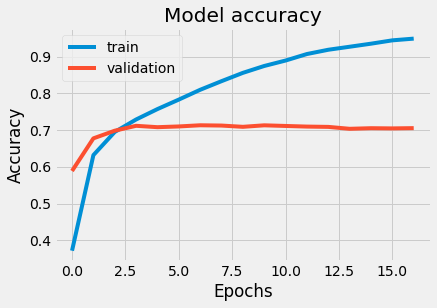

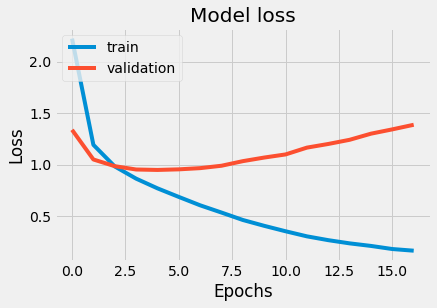

In [0]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print('\n')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# ***Preparing Testing Data***

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/Data/test.csv')
df_test.shape

(20665, 11)

In [0]:
df_test.head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [0]:
dfWineTest = df_test[['review_description']]
dfWineTest.head(5)

,review_description
0,Nicely differentiated from the companion Stewa...
1,"Charred, smoky, herbal aromas of blackberry tr..."
2,"Slightly sour and funky in earth, this is a re..."
3,"This concentrated, midnight-black Malbec deliv..."
4,"Earthy aromas suggesting grilled porcini, leat..."


In [0]:
# Converting testing text data to numerical indexes
wine_seqs_test = tokenizer.texts_to_sequences(dfWineTest['review_description'])
print(len(wine_seqs_test))
wine_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(wine_seqs_test, maxlen=SEQ_LENGTH, padding="post")

20665


# ***Predictions***

In [0]:
predictions = model.predict(wine_seqs_test)

In [0]:
final_predictions = []
for i in range(predictions.shape[0]):
  pred = np.argsort(predictions[i])[-1]
  pred_label = decode_label([pred]).replace('_',' ')
  final_pred = ' '.join(pred_label.capitalize() for pred_label in pred_label.split())
  final_predictions.append(final_pred)

# ***Preparing final CSV file***

In [0]:
df_test_predicted = pd.read_csv('/content/drive/My Drive/Data/test.csv')
df_test_predicted['variety'] = final_predictions
df_test_predicted.shape

(20665, 12)

In [0]:
df_test_predicted.head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars,Pinot Noir
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards,Malbec
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime,Chardonnay
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio,Malbec
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole,Sangiovese


In [0]:
df_test_predicted.to_csv('test_output.csv')